# Market Analysis — Italian Restaurants in Manhattan

Exploratory data analysis, segmentation by category, and regression modeling to identify price drivers in the Italian restaurant market in NYC.

## 1. Setup & Data Loading

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway

# Plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

COLORS = {"Pizzeria": "#8B1A1A", "Restaurant": "#D4A0A0", "Panini": "#4A0000", "Street Food": "#C0504D"}

In [9]:
# Load dataset
df = pd.read_csv("../data/nyc_italian_restaurants.csv")

# Drop unnecessary columns
cols_to_drop = [c for c in ["Name", "Latitude", "Longitude", "Case"] if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Rename category column for clarity
df = df.rename(columns={"C": "Category"})

print(f"Dataset: {df.shape[0]} restaurants, {df.shape[1]} features")
print(f"\nCategories: {df['Category'].value_counts().to_dict()}")
df.head()

Dataset: 172 restaurants, 9 features

Categories: {'Pizzeria': 94, 'Restaurant': 34, 'Panini': 23, 'Street Food': 21}


,Restaurant,Price,Food,Decor,Service,East,latitude,longitude,Category
0,Daniella Ristorante,43,22,18,20,0,40.746831,-73.996758,Pizzeria
1,Tello's Ristorante,32,20,19,19,0,40.743421,-73.999537,Panini
2,Biricchino,34,21,13,18,0,40.748864,-73.995519,Street Food
3,Bottino,41,20,20,17,0,40.748485,-74.003313,Pizzeria
4,Da Umberto,54,24,19,21,0,40.739581,-73.995910,Pizzeria


In [10]:
df.info()
print("\nMissing values:\n", df.isnull().sum())
print("\nDescriptive statistics:")
df.describe().round(2)

<class 'pandas.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  172 non-null    str    
 1   Price       172 non-null    int64  
 2   Food        172 non-null    int64  
 3   Decor       172 non-null    int64  
 4   Service     172 non-null    int64  
 5   East        172 non-null    int64  
 6   latitude    172 non-null    float64
 7   longitude   172 non-null    float64
 8   Category    172 non-null    str    
dtypes: float64(2), int64(5), str(2)
memory usage: 12.2 KB

Missing values:
 Restaurant    0
Price         0
Food          0
Decor         0
Service       0
East          0
latitude      0
longitude     0
Category      0
dtype: int64

Descriptive statistics:


,Price,Food,Decor,Service,East,latitude,longitude
count,172.00,172.00,172.00,172.00,172.00,172.00,172.00
mean,42.75,20.76,17.69,19.44,0.63,40.76,-73.97
std,9.29,2.24,2.67,2.12,0.48,0.02,0.02
min,19.00,16.00,6.00,14.00,0.00,40.71,-74.01
25%,36.00,19.00,16.00,18.00,0.00,40.75,-73.99
50%,43.00,21.00,18.00,20.00,1.00,40.76,-73.98
75%,50.00,22.00,19.00,21.00,1.00,40.77,-73.96
max,65.00,28.00,25.00,24.00,1.00,40.80,-73.93


## 2. Exploratory Data Analysis

### 2.1 Distributions

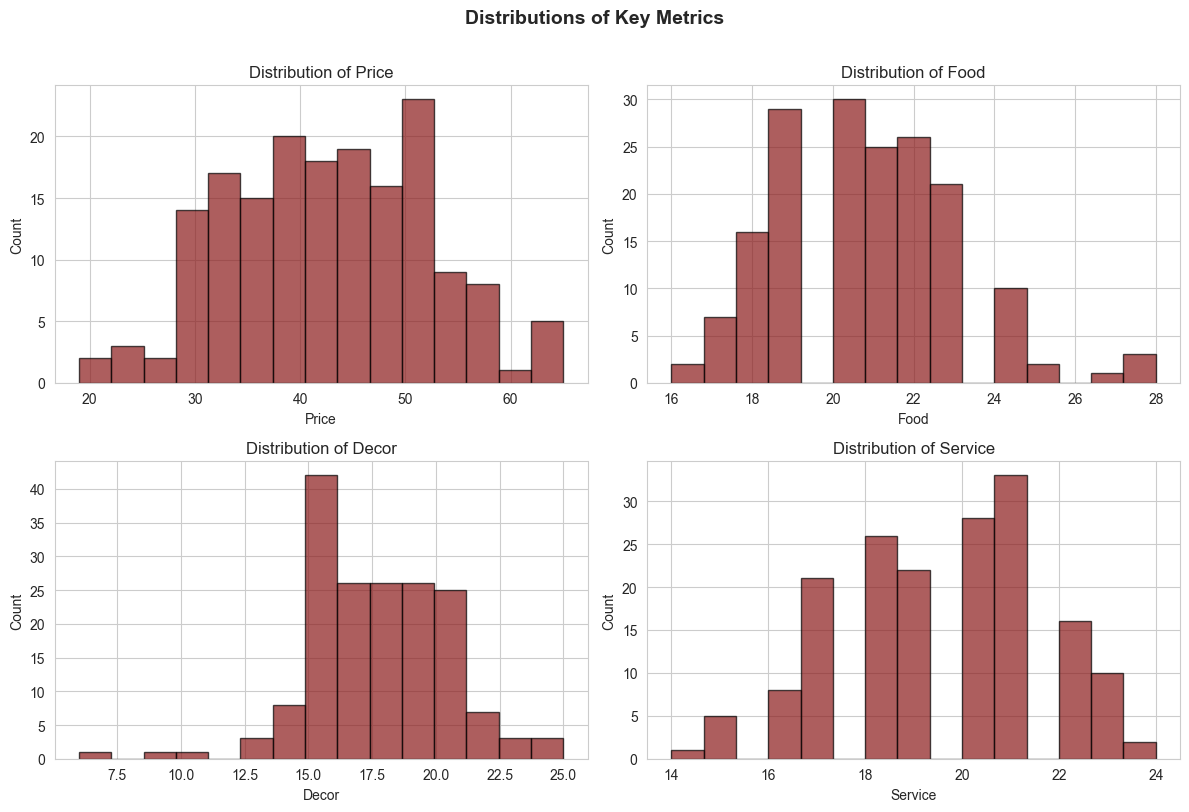

In [11]:
# Distribution of all numeric features
num_cols = ["Price", "Food", "Decor", "Service"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, num_cols):
    df[col].hist(bins=15, ax=ax, edgecolor="black", color="#8B1A1A", alpha=0.7)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.suptitle("Distributions of Key Metrics", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

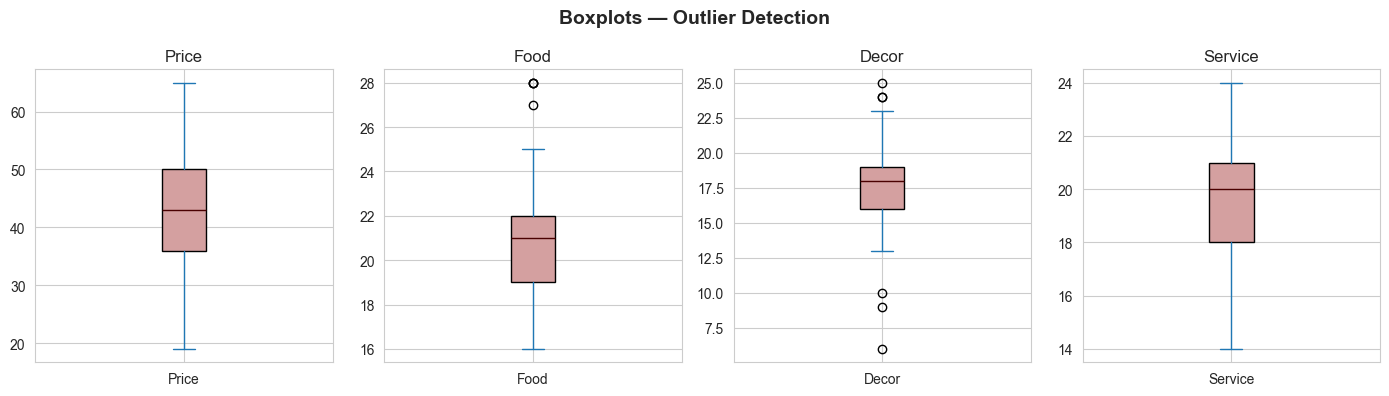

In [12]:
# Boxplots side by side
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for ax, col in zip(axes, num_cols):
    df[col].plot(kind="box", vert=True, ax=ax, patch_artist=True,
                 boxprops=dict(facecolor="#D4A0A0"), medianprops=dict(color="#4A0000"))
    ax.set_title(col, fontsize=12)

plt.suptitle("Boxplots — Outlier Detection", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### 2.2 Distributions by Category

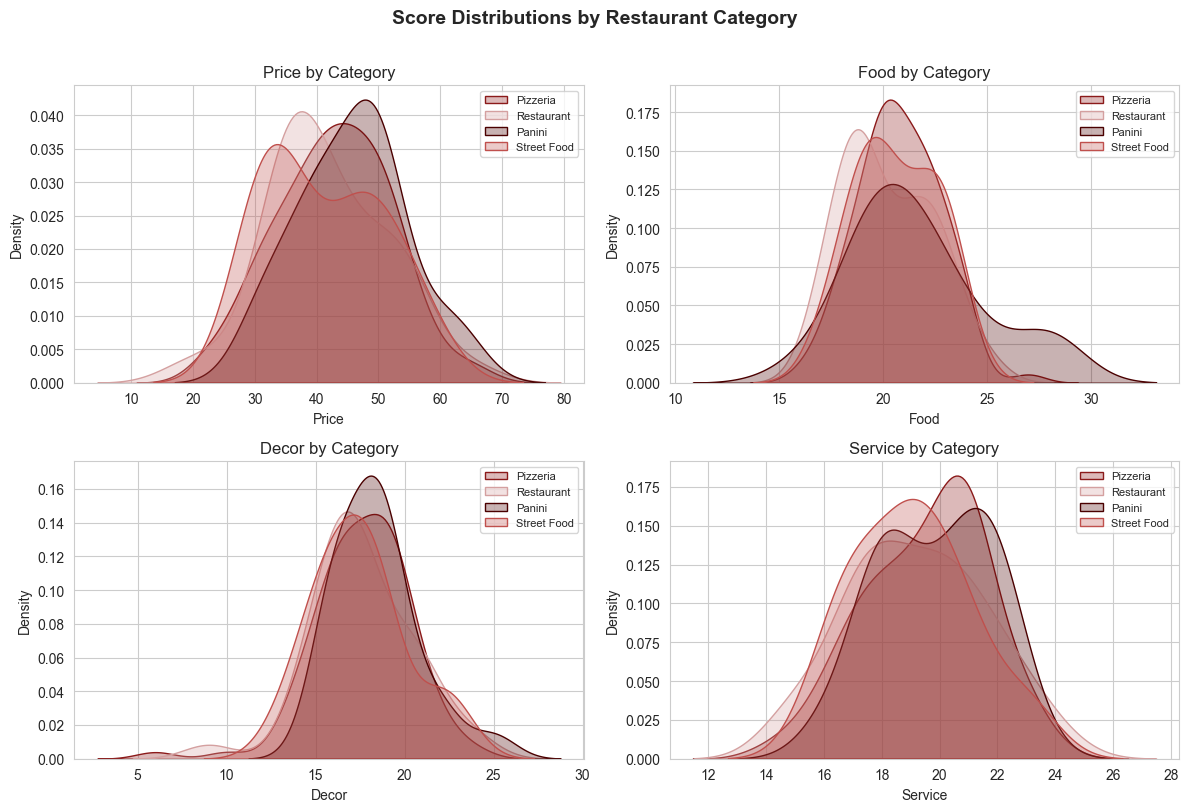

In [13]:
# KDE plots by category for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, num_cols):
    for cat, color in COLORS.items():
        subset = df[df["Category"] == cat][col].dropna()
        if len(subset) > 1:
            sns.kdeplot(subset, ax=ax, label=cat, color=color, fill=True, alpha=0.3)
    ax.set_title(f"{col} by Category", fontsize=12)
    ax.legend(fontsize=8)

plt.suptitle("Score Distributions by Restaurant Category", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.3 Category Comparison

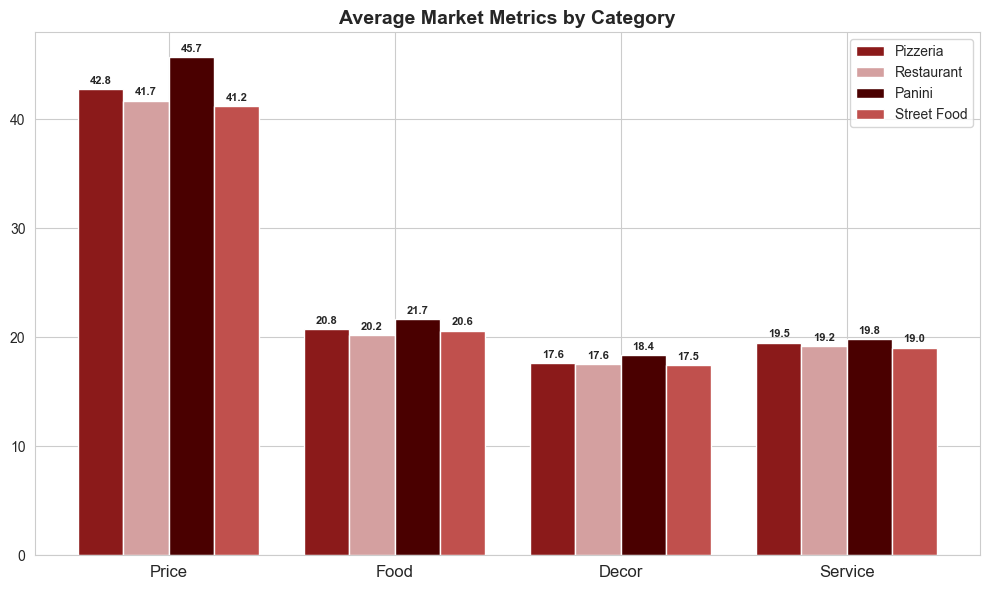

In [14]:
# Average metrics by category
avg_by_cat = df.groupby("Category")[num_cols].mean().reindex(COLORS.keys())

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(num_cols))
width = 0.2

for i, (cat, color) in enumerate(COLORS.items()):
    vals = avg_by_cat.loc[cat]
    bars = ax.bar(x + i * width, vals, width, label=cat, color=color)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f"{val:.1f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(num_cols, fontsize=12)
ax.set_title("Average Market Metrics by Category", fontsize=14, fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

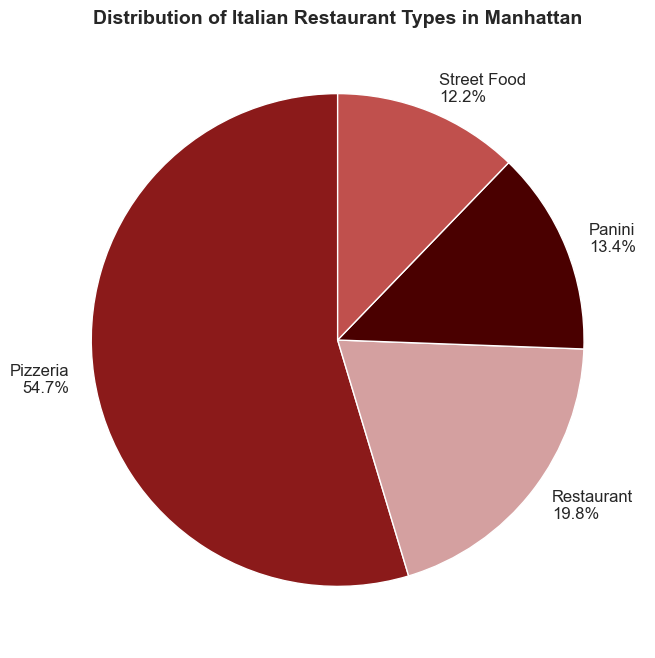

In [15]:
# Category distribution (pie chart)
counts = df["Category"].value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=[f"{cat}\n{pct:.1f}%" for cat, pct in zip(counts.index, 100*counts/counts.sum())],
       colors=[COLORS.get(c, "#999") for c in counts.index],
       startangle=90, textprops={"fontsize": 12})
ax.set_title("Distribution of Italian Restaurant Types in Manhattan", fontsize=14, fontweight="bold")
plt.show()

## 3. Correlation & Relationships

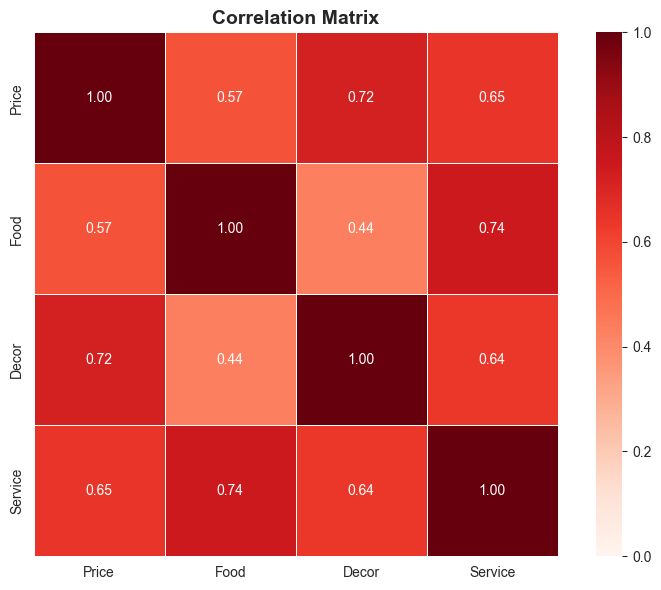

In [16]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f", ax=ax,
            linewidths=0.5, square=True, vmin=0, vmax=1)
ax.set_title("Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

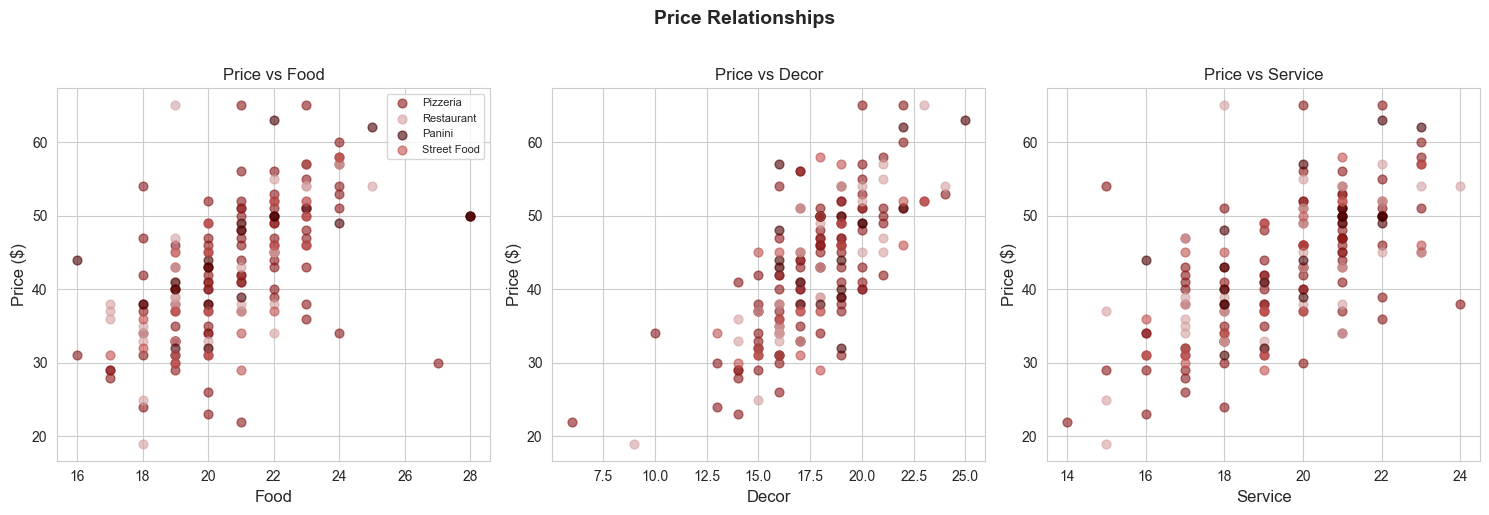

In [17]:
# Scatter plots: Price vs each score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col in zip(axes, ["Food", "Decor", "Service"]):
    for cat, color in COLORS.items():
        subset = df[df["Category"] == cat]
        ax.scatter(subset[col], subset["Price"], color=color, label=cat, alpha=0.6, s=40)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Price ($)", fontsize=12)
    ax.set_title(f"Price vs {col}", fontsize=12)

axes[0].legend(fontsize=8)
plt.suptitle("Price Relationships", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

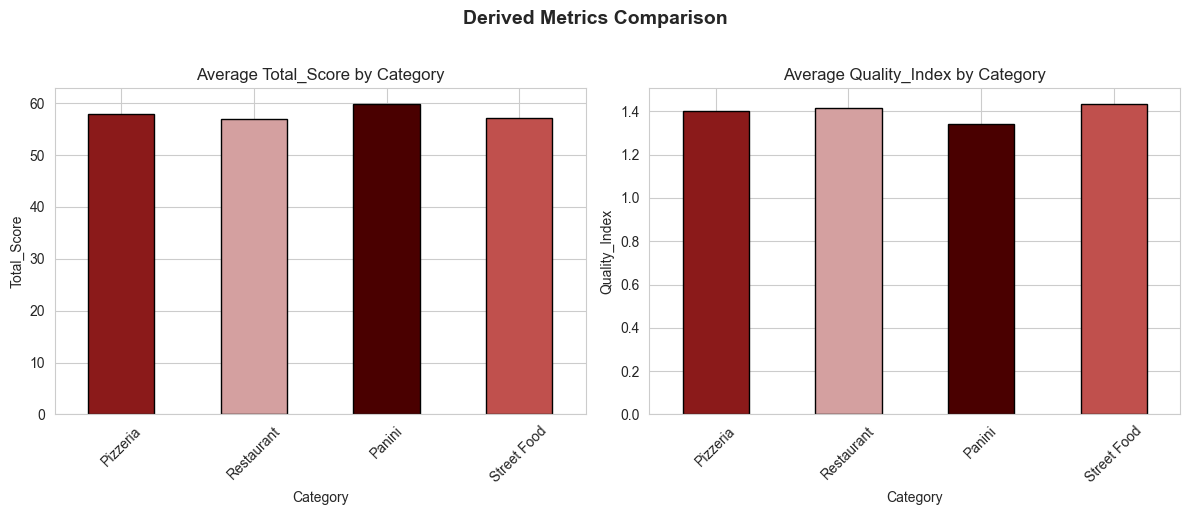

In [18]:
# Create derived features
df["Total_Score"] = df["Food"] + df["Service"] + df["Decor"]
df["Quality_Index"] = df["Total_Score"] / df["Price"]

# Compare across categories
derived_cols = ["Total_Score", "Quality_Index"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in zip(axes, derived_cols):
    df.groupby("Category")[col].mean().reindex(COLORS.keys()).plot(
        kind="bar", ax=ax, color=list(COLORS.values()), edgecolor="black")
    ax.set_title(f"Average {col} by Category", fontsize=12)
    ax.set_ylabel(col)
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("Derived Metrics Comparison", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 5. Regression Analysis — What Drives the Price?

In [19]:
# OLS Regression: Price ~ Food + Decor + Service + East
X = df[["Food", "Decor", "Service", "East"]].dropna()
y = df.loc[X.index, "Price"]
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     67.36
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           7.67e-34
Time:                        10:17:56   Log-Likelihood:                -544.23
No. Observations:                 172   AIC:                             1098.
Df Residuals:                     167   BIC:                             1114.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.9777      4.450     -4.714      0.0

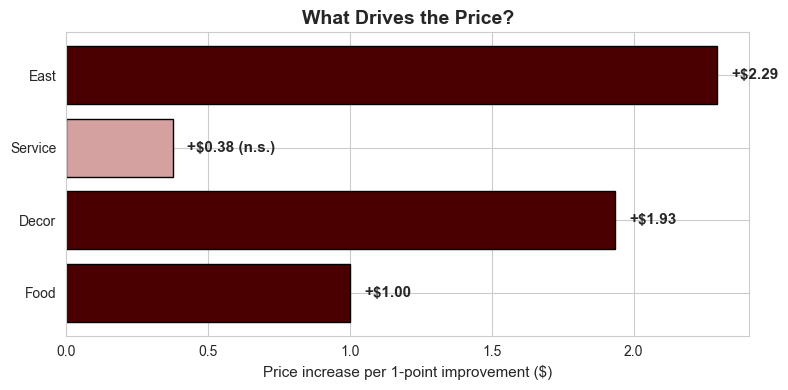


R² = 0.6173 | Adjusted R² = 0.6082

Key insight: Decor (+$1.93/point) is the strongest price driver, followed by Food (+$1.00/point).


In [20]:
# Visualize regression coefficients
coefs = model.params.drop("const")
pvals = model.pvalues.drop("const")

fig, ax = plt.subplots(figsize=(8, 4))
colors_bar = ["#4A0000" if p < 0.05 else "#D4A0A0" for p in pvals]
bars = ax.barh(coefs.index, coefs.values, color=colors_bar, edgecolor="black")

for bar, val, pval in zip(bars, coefs.values, pvals):
    label = f"+${val:.2f}" + ("" if pval < 0.05 else " (n.s.)")
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            label, va="center", fontsize=11, fontweight="bold")

ax.set_xlabel("Price increase per 1-point improvement ($)", fontsize=11)
ax.set_title("What Drives the Price?", fontsize=14, fontweight="bold")
ax.axvline(x=0, color="black", linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\nR² = {model.rsquared:.4f} | Adjusted R² = {model.rsquared_adj:.4f}")
print(f"\nKey insight: Decor (+${coefs['Decor']:.2f}/point) is the strongest price driver, followed by Food (+${coefs['Food']:.2f}/point).")

## 6. Geographic Analysis

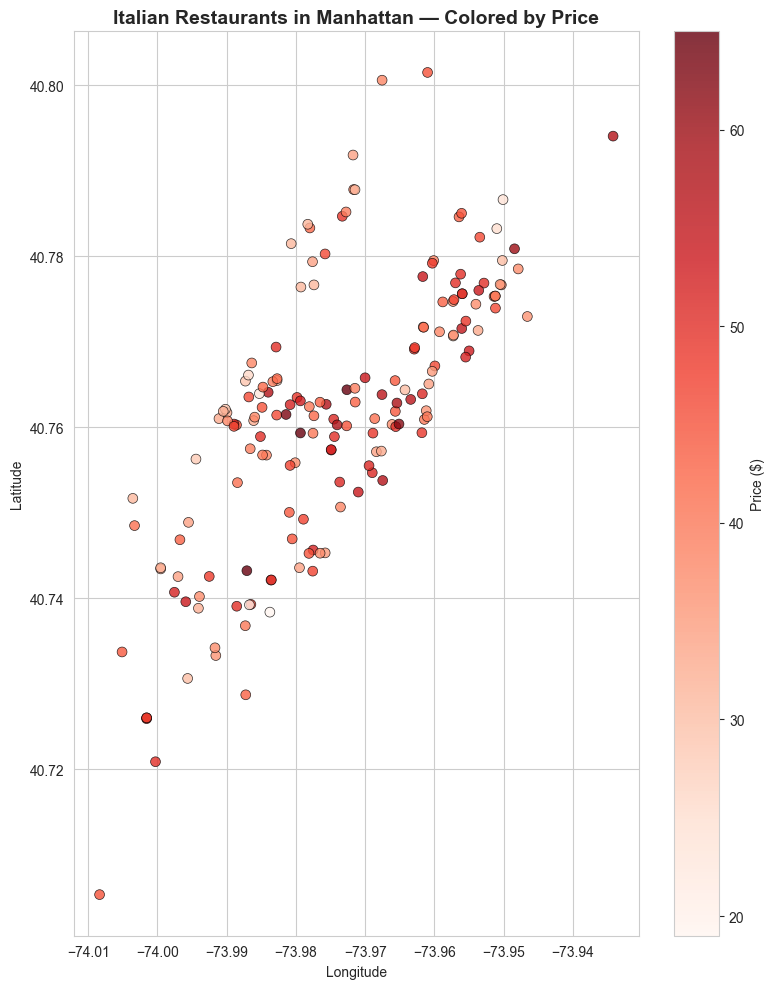

In [21]:
# Price map
fig, ax = plt.subplots(figsize=(8, 10))
scatter = ax.scatter(df["longitude"], df["latitude"], c=df["Price"],
                     cmap="Reds", s=50, edgecolors="black", linewidth=0.5, alpha=0.8)
plt.colorbar(scatter, ax=ax, label="Price ($)")
ax.set_title("Italian Restaurants in Manhattan — Colored by Price", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## 7. Key Takeaways

1. **Pizzerias dominate** the market (54.7%), while Panini shops achieve the highest average scores
2. **Decor is the #1 price driver** (+\$1.93 per point) — investing in ambiance has the highest return
3. **Food quality** is the second driver (+\$1.00 per point), while Service is not statistically significant
4. **Restaurants are concentrated** in Upper East Side and Midtown — southern Manhattan (SoHo) is underserved
5. The **Panini category** offers the best quality-price ratio, making it a strong format for market entry